<a href="https://colab.research.google.com/github/EliseuODaniel/analise_de_sentimentos_eleicao/blob/main/analise_sentimento_com_bert_Tweets_lula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimento com Bert

## Projeto integrador

## Classificação de Texto

utilização da arquitetura BERTimbau, versão em Português do BERT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.6 MB/s 
     |████████████████████████████████| 7.6 MB 49.3 MB/s 
     |████████████████████████████████| 163 kB 60.6 MB/s 


In [3]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [4]:

import pandas as pd
import csv
from random import shuffle
import nltk
nltk.download('punkt')

# Lê o csv e transforma num dataframe

full_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets_lula_cleaned-categorizado2corrigido.csv', sep=';')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24698 entries, 0 to 24697
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       24698 non-null  int64  
 1   date     24698 non-null  object 
 2   content  24695 non-null  object 
 3   label    836 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 771.9+ KB


In [6]:
# Drop rows with any empty cells in collumn 'label'
df = full_df.dropna(subset=['label'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 23200
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       836 non-null    int64  
 1   date     836 non-null    object 
 2   content  836 non-null    object 
 3   label    836 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.7+ KB


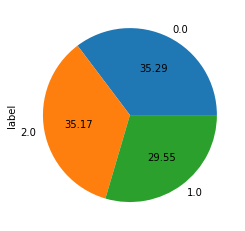

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

#  mostra a proporção de cada label, se não está balanceado, acurácia não é uma boa métrica
df['label'].value_counts().plot.pie(autopct='%.2f')

In [9]:
# converte dataframe em lista de listas
tweets_list = df.values.tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


presidente         1301
brasil             1029
ladrão              918
porque              861
agora               743
inocente            734
simonetebetbr       712
thiagoresiste       693
votar               670
cara                667
voto                655
povo                639
ricardostuckert     609
governo             580
gente               575
turno               534
aqui                517
ganhar              512
anos                498
tudo                494
dtype: int64


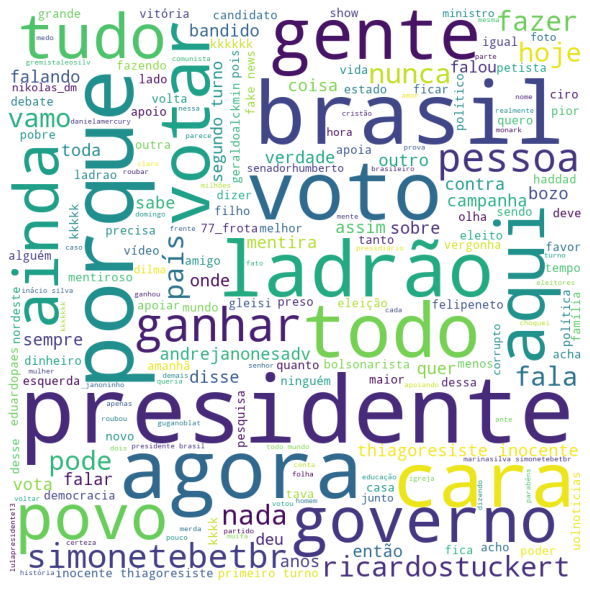

In [10]:
# cria uma nuvem de palavras


import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words = stop_words + list(['lulaoficial','lula',',','.','https', ':','!', '#', '@', '?', '/', 'O', 'vai', '|', '–','pra', 'a', 'e', '-'])

def remove_stopwords(x):
  word_tokens = nltk.word_tokenize(x)
  # print(word_tokens)
  filtered_sentence = ' '.join([w for w in word_tokens if not (w in stop_words or len(w)<4)]) 
  return filtered_sentence

tweets_lula = full_df

#convert to string and lowercase sentences 
tweets_lula['content'] = tweets_lula['content'].astype(str).str.lower()


tweets_lula['filtered_text'] = tweets_lula['content'].apply(lambda x: remove_stopwords(x))

# filter tweets_lula by day - para caso queira mostrar quais palavras foram mais citadas a cada dia
# for day in tweets_lula['date'].unique():
#     print("\nday: ", day)
#     tweets_lula_day = tweets_lula[tweets_lula['date'] == day]
#     word_count = pd.Series(' '.join(tweets_lula_day['filtered_text'].str.lower()).split()).value_counts()[:20]
#     print(word_count)

word_count = pd.Series(' '.join(tweets_lula['filtered_text'].str.lower()).split()).value_counts()[:20]
print(word_count)

# create a word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(tweets_lula['filtered_text']))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

cria uma lista com dicionarios de reviews e rating

In [11]:
#print(tweets_list)

In [12]:
tweets = [str(w[2]) for w in tweets_list]
ratings = [int(w[3]) for w in tweets_list]
data = [{ 'X': tweets, 'y': rating } for (tweets, rating) in zip(tweets, ratings)]

In [13]:
#print(data)

In [14]:
#print(type(data))
#print(data)

Separando os dados em conjunto de treino e teste

In [15]:
size = int(len(data) * 0.1)
treino = data[2*size:] #  0.2 - 1
validacao = data[size:2*size] # 0.1:0.2
teste = data[:size]  # 0:0.1

len(treino), len(validacao), len(teste)

(670, 83, 83)

BERTimbau - documentação [este link](https://github.com/neuralmind-ai/portuguese-bert).

Configurando hiper parâmetros

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # define qual será o acelerador gráfico onde o modelo será processado
nclasses = 3  # número de classes/labels que classificam  os tweets (0 = negativo, 1 = indefinido, 2 = positivo)
nepochs = 10  # número de épocas (valor inicial: 5)
batch_size = 8 # número mínimo de frases que são previstas por vez - recomendação autores bert: Batch size: 16, 32 (maior batch usa menos memória)
batch_status = 32  # a cada quantas batches avalia o status - numero menor pra dataset menor
learning_rate = 2e-5  # taxa de aprendizado - recomendação autores bert Learning rate (Adam): 5e-5, 3e-5, 2e-5 (1e-5 usa menos memória)
early_stop = 2  # critério de parada, quantas epocas sem melhora do f1 para parar o aprendizado

max_length = 200 # tamanho maximo de cada frase
write_path = 'model'

Separando os dados em batches de treino e teste



In [17]:
from torch.utils.data import DataLoader

traindata = DataLoader(treino, batch_size=batch_size, shuffle=True)
validationdata = DataLoader(validacao, batch_size=batch_size, shuffle=True)
testdata = DataLoader(teste, batch_size=batch_size, shuffle=True)

In [18]:
# conteúdo do dataloader
for batch_idx, inp in enumerate(traindata):
    print(batch_idx) #o índice do batch
    print(inp) # os batches, dicionário de X com os textos e Y transformado em tensor com os labels
    break

0
{'X': ['MauroDoroche Se vocês querem  ser roubados  votem no Lula quando você for assaltado  ou roubado por um bandido  faça o L ', 'JornalOGlobo Gente isso foi armação daquele pinguço do Lula! Chega até ser engraçado o nível baixo que o PT consegue chegar pra tentar manipular a população. Kkkk', 'CiaVermelho Lula Sem dúvidas 13', 'O Jornal Nacional toda noite passa o dia da campanha dos presidênciaveis:', 'UOL Lula sempre na frente kkkkkk', 'Lula ', ' URGENTE ', 'LibertariosUru1 Merece ganar Lula'], 'y': tensor([0, 0, 2, 1, 2, 1, 1, 2])}


instanciando tokenizador, modelo, função de erro e otimizador:

In [19]:
# instancia o tokenizador
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)  # para utilizar o BERTinbal large: 'neuralmind/bert-large-portuguese-cased'
#bertinbal menor: 'neuralmind/bert-base-portuguese-cased'
#  instancia o modelo
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased', num_labels=nclasses).to(device)

# seleciona o otimizador 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# congela os pesos do BERT pré-treinado
for param in model.base_model.parameters():
    param.requires_grad = False

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


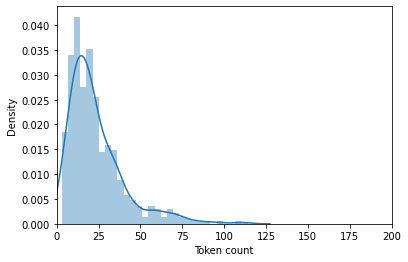

In [20]:
import seaborn as sns
# verificando a distribuição e o tamanho máximo dos tokens
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

Funcionamento do tokenizador

In [21]:
tokens = tokenizer.encode("bonito carro", return_tensors="pt")
print("frase tokenizada no formato de tensor pytorch:")
tokens[0]
# codifiga cada palavra com um token e adiciona o token de CLS (classificação) e de final de frase (SEP)

frase tokenizada no formato de tensor pytorch:


tensor([  101, 22003,  3883,   102])

In [22]:
tokens = tokenizer.encode("carro bonito", return_tensors="pt").to(device)
print("frase tokenizada no formato de tensor pytorch:")
tokens[0]

frase tokenizada no formato de tensor pytorch:


tensor([  101,  3883, 22003,   102], device='cuda:0')

In [23]:
print("frase destokenizada:")
tokenizer.decode(tokens[0])

frase destokenizada:


'[CLS] carro bonito [SEP]'

funcionamento do modelo

In [24]:
result = model(tokens)
result
# a saída é uma lista de scores one-hot encoded
# como ao ser instanciado o modelo, foi escolhido o número de classes como 3, a saída será de 3 números diferentes
# cada posição com um significado diferente, conforme o que for utilizado nos dados de treino
# no exemplo a posição 1 (0.0417) é a maior (como o modelo ainda não foi treinado, o significado é aleatório)
# caso o modelo for treinado com a classificação 0=ruim, 1=neutro, 2=bom, a posição com número maior irá indicar o sentimento geral da frase


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1912, -0.1027, -0.1654]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [25]:
#exemplo do tokenizer em funcionamento
# conteúdo do dataloader
for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    print(texts[0],"\n")
    tokens = tokenizer.encode(texts[0], return_tensors="pt")
    print("frase tokenizada no formato de tensor pytorch:")
    print(tokens[0])
    print("label da frase tokenizada:")
    print(labels[0],"\n")

    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)

    print(f"inputs[0]:\n {inputs[0]}\n")
    print(f"chaves do dicionário inputs:\n {inputs.keys()}\n")
    print(f'input_ids (frase tokenizada):\n {inputs["input_ids"][0]}\n')
    print(f'token_type_ids:\n {inputs["token_type_ids"][0]}\n')
    print(f'attention_mask:\n {inputs["attention_mask"][0]}')
    

    # saída é:
    # input_ids = transformações do texto em números, embeddings. onde 101 é token inicial
    # attention_mask = tensor que diz quais tokens devem receber atenção pelo modelo
    break


Lula se esquiva na indicação de possíveis nomes para ministérios  

frase tokenizada no formato de tensor pytorch:
tensor([  101, 11124,   176,  3686,  1319,   229,  9403,   125,  6809,  3360,
          221, 12080, 22281,   102])
label da frase tokenizada:
tensor(0) 

inputs[0]:
 Encoding(num_tokens=38, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

chaves do dicionário inputs:
 dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids (frase tokenizada):
 tensor([  101, 11124,   176,  3686,  1319,   229,  9403,   125,  6809,  3360,
          221, 12080, 22281,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')

token_type_ids:
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], devi

In [26]:
# funcionamento do modelo
with torch.no_grad():
    model.eval()
    output = model(inputs['input_ids'], inputs['attention_mask'])

    #resultado (passa informações no modelo e ele gera uma lista contendo as saídas numa lista de tensores)
    #este modelo já tem camadas densas anexadas à saída do encoder que geram uma lista de probabilidades 
    #o resultado do modelo pre treinado

    #formato da saída:
    print(output[0][0])

    # como definiu-se 3 labels, a saída é um tensor de 3 números para cada label respectiva
    # onde o maior número significa a probabilidade de ser aquela label
    # 0 = positivo, 1 = indefinido, 2 = positivo
    print(output[0].shape) # o shape da saída mostra quantas frases tinha em cada batch (primeiro número) e quantas labels em cada frase(segundo número)


    

tensor([-0.0354,  0.0616, -0.0168], device='cuda:0')
torch.Size([8, 3])


In [27]:
# para extrair a informação do resultado:
torch.argmax(result.logits)

tensor(0, device='cuda:0')

Definindo a função de avaliação do modelo

In [28]:
def evaluate(model, validationdata):
  """
  avalia o desempenho do modelo que está sendo treinado baseado nos dados de validacao
  """
  # coloca o modelo no modo de avaliação
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(validationdata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']
    
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    
    # cria um tensor com os labels preditos no output
    pred_labels = torch.argmax(output.logits, 1)

    # print(f"texto: {texts}, rótulo correto: {labels}, predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito
    
    # adiciona cada novo label às listas y_real e y_pred(ito)
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    # a cada certa quantidade de itens preditos, printa a % de progresso e o número de itens preditos
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  # chama o classification_report do scikitlearn para calcular o resultado após predizer todas as linhas de teste
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negative', 'Neural', 'Positive'])) # identifica os labels 0, 1 e 2 como negativo, neutro e positivo
  # retorna f1 e acurácia
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [29]:
max_f1, repeat = 0, 0

#  passa por todas as épocas de treino
for epoch in range(nepochs):
  #seleciona o modo de treino do modelo
  model.train()
  losses = []

  for batch_idx, inp in enumerate(traindata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']

    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # zera os gradientes acumulados em buffer 
    optimizer.zero_grad()
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs, labels=labels.to(device))

    # calcula a perda
    loss = output.loss
    losses.append(float(loss))

    # faz o Backpropagation no modelo- com o otimizador definido anteriormente (AdamW)
    loss.backward()
    optimizer.step()

    # mostra o andamento do treinamento
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(\
        epoch, # número da época
        batch_idx+1, # número do batch
        len(traindata), # número total de dados de treino
        100. * batch_idx / len(traindata), # % de dados treinados
        float(loss), # perda atual
        round(sum(losses) / len(losses), 5) # perda acumulada
        ))

  # se passou a 1a época, descongela os pesos do Bert pretreinado
  if epoch == 0: 
    for param in model.base_model.parameters():
        param.requires_grad = True

  # ao terminar cada época, avalia o modelo
  f1, acc = evaluate(model, validationdata)
  print('F1: ', f1, 'Accuracy: ', acc)

  # salva o modelo somente se f1 melhorou em relação à epoch anterior
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  # se por duas épocas o f1 não melhorou, para de treinar o modelo
  if repeat == early_stop:
    break

Train Epoch: 0 [32/84 (37%)]	Loss: 1.121814	Total Loss: 1.110230
Train Epoch: 0 [64/84 (75%)]	Loss: 1.076346	Total Loss: 1.110150
              precision    recall  f1-score   support

    Negative       0.36      0.42      0.39        31
      Neural       0.25      0.11      0.15        18
    Positive       0.49      0.56      0.52        34

    accuracy                           0.41        83
   macro avg       0.37      0.36      0.35        83
weighted avg       0.39      0.41      0.39        83

F1:  0.39153869460826174 Accuracy:  0.40963855421686746
Saving best model...
Train Epoch: 1 [32/84 (37%)]	Loss: 0.945473	Total Loss: 1.059380
Train Epoch: 1 [64/84 (75%)]	Loss: 1.165157	Total Loss: 1.009480
              precision    recall  f1-score   support

    Negative       0.57      0.74      0.65        31
      Neural       0.67      0.56      0.61        18
    Positive       0.64      0.53      0.58        34

    accuracy                           0.61        83
   macro a

In [30]:
  # avaliação final do modelo nos dados de teste
  f1, acc = evaluate(model, testdata)
  print('F1: ', f1, 'Accuracy: ', acc)

              precision    recall  f1-score   support

    Negative       0.70      0.74      0.72        31
      Neural       0.70      0.64      0.67        25
    Positive       0.78      0.78      0.78        27

    accuracy                           0.72        83
   macro avg       0.72      0.72      0.72        83
weighted avg       0.72      0.72      0.72        83

F1:  0.7222640562248995 Accuracy:  0.7228915662650602


In [31]:
texts = "lula é horrível"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: lula é horrível, rótulo predito pelo modelo: 0


In [32]:
texts = "lula é ótimo, votem 13"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: lula é ótimo, votem 13, rótulo predito pelo modelo: 2


In [33]:
texts = "tweet aleatório sem sentido"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: tweet aleatório sem sentido, rótulo predito pelo modelo: 1


In [34]:
#reduced_df = full_df.head(10000) # seleciona apenas 5000 linhas para teste
reduced_df = full_df

In [35]:

# iterates through the dataframe tweets_lula and prints the text of the 'content' column at each iteration
for index, row in reduced_df.iterrows():
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(str(row['content']), return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    # cria um tensor com os labels preditos no output e extrai a predição do tensor
    reduced_df['label'][index] = torch.argmax(output.logits).item()

    if index % 2000 == 0:
      print(f"{index}/{len(reduced_df)}")
    #print(reduced_df['label'])
    


0/24698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2000/24698
4000/24698
6000/24698
8000/24698
10000/24698
12000/24698
14000/24698
16000/24698
18000/24698
20000/24698
22000/24698
24000/24698


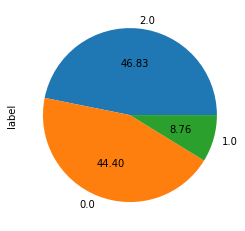

In [36]:
# nmostra a proporção de labels no resultado final total
reduced_df['label'].value_counts().plot.pie(autopct='%.2f')

In [37]:
# transforma a data em time series
reduced_df['date'] = pd.to_datetime(full_df['date'])


In [38]:
# agrupa o total de labels por dia
reduced_df_grouped = reduced_df.groupby(['label', pd.Grouper(key='date', freq='D')]).count()

In [39]:
reduced_df_grouped.head(10)

id  content  filtered_text
label date                                   
0.0   2022-10-02  304      304            304
      2022-10-03  363      363            363
      2022-10-04  454      454            454
      2022-10-05  431      431            431
      2022-10-06  491      491            491
      2022-10-07  471      471            471
      2022-10-08  415      415            415
      2022-10-09  444      444            444
      2022-10-10  377      377            377
      2022-10-11  430      430            430

In [40]:
# faz o pivot transformando as linhas de diferente labels em colunas
reduced_df_grouped = reduced_df_grouped.pivot_table(index='date', columns='label', values='content')

In [41]:
#remove coluna com label 1 (indefinidos)
reduced_df_grouped = reduced_df_grouped.drop(columns=[1])

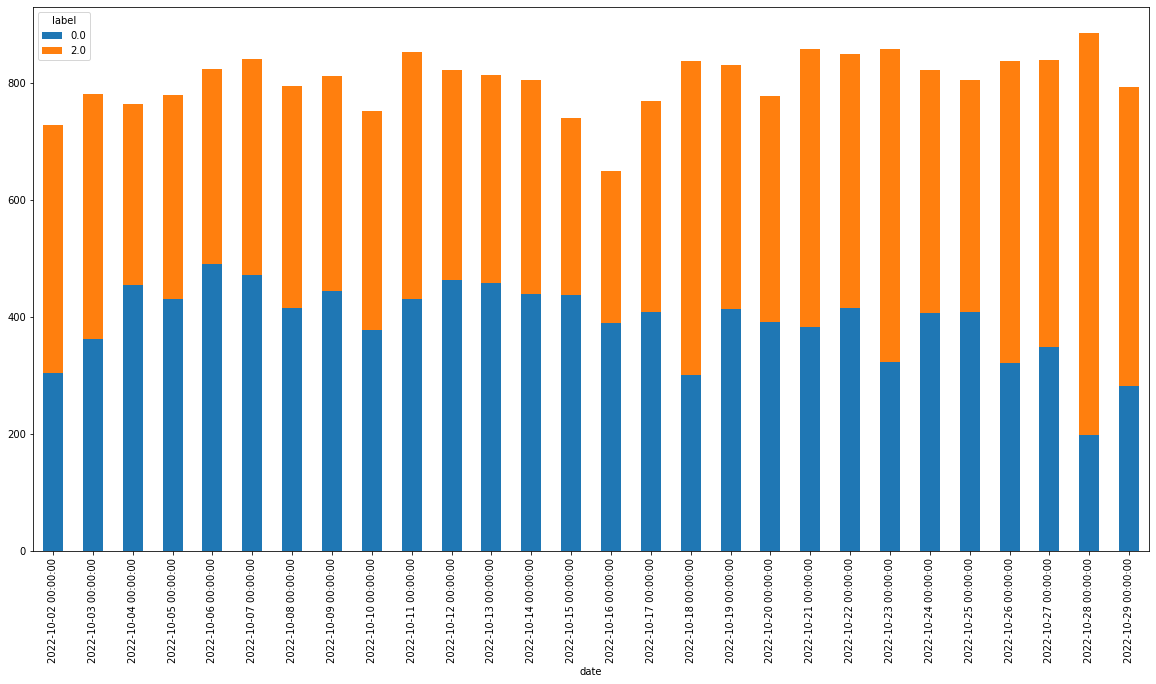

In [42]:
#plota o gráfico
reduced_df_grouped.plot(kind='bar', stacked=True, figsize=(20,10))

Text(0, 0.5, 'Porcentagem de cada Sentimento')

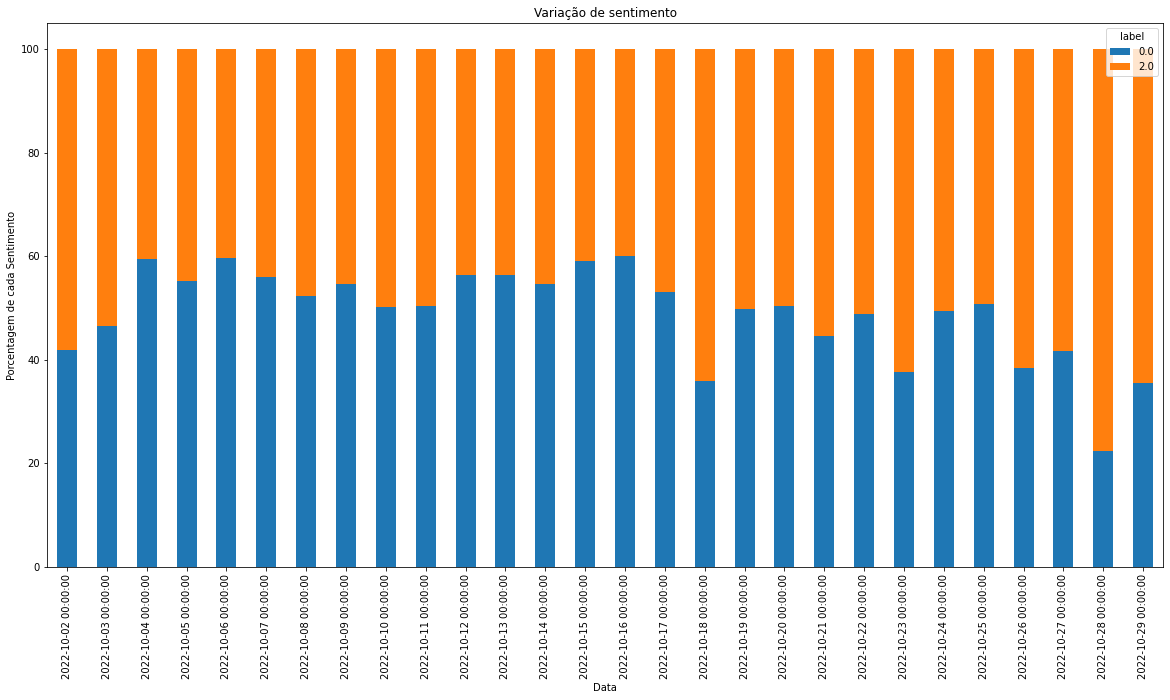

In [43]:
stacked_data = reduced_df_grouped.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True,  figsize=(20,10))
plt.title("Variação de sentimento")
plt.xlabel("Data")
plt.ylabel("Porcentagem de cada Sentimento")